In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision # for images
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt

In [2]:
empty_mtx = torch.empty(5, 3)
rand_mtx  = torch.rand(5, 3)
zero_mtx  = torch.zeros(5, 3, dtype=torch.float)
data_mtx  = torch.tensor([5.5, 3.])
new_mtx   = empty_mtx.new_ones(5, 3, dtype=torch.double)
like_mtx  = torch.randn_like(empty_mtx, dtype=torch.float)
like_mtx.size()
rand_mtx + zero_mtx
result    = empty_mtx.new_ones(5, 3)
add_mtx   = torch.add(rand_mtx, zero_mtx, out=result)
result
result.add_(result) # add result to itself, mutation have postfix _, such as transpose t_()
resize_mtx= result.view(15) # view result matrix as vector
one_mtx   = torch.randn(1)
one_mtx.item() # mtx of size 1 can be accessed using item()
one_mtx.numpy() # converting pytorch tensor to numpy

#converting numpy array to torch tensor
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a) # b is just a reference

array([2., 2., 2., 2., 2.])

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(5, 3, device=device, dtype=torch.float)
    y = torch.ones_like(x, device=device)
    z = x + y
    print(z)
    print(z.to('cpu', torch.float))

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]], device='cuda:0')
tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])


In [4]:
#using autograd
x = torch.ones(2, 2, requires_grad=True, dtype=torch.float)
y = x + 2
print(y.grad_fn)
z = y * y * 3.
out = z.mean()
print(z, out)
out.backward()
print(x.grad)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [5]:
# vector-jacobian product
x = torch.randn(3, requires_grad=True)
y = x * 2
while y.data.norm() < 1000:
    y = y * 2.
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)
print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


In [6]:
# CNN for MNIST digit recognition
# Torch only supports SGD with minibatch, a single sample need to apply input.unsqeeze(0) to add a fake batch
# input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d -> view -> linear -> relu -> linear ->
# relu -> linear -> MSELoss -> loss
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channel, 3*3 square convolution kernel
        # Conv2d will take in a 4D tensor of nSamples * nChannels * Height * Width
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120) # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # if the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) #conv1's weight

10
torch.Size([6, 1, 3, 3])


In [8]:
# test with 1 random 32 * 32 input
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)
net.zero_grad() # zero the gradients

# compute loss
output = net(input)
target = torch.randn(10)
target = target.view(1, -1) # make it the same shape as output
criterion = nn.MSELoss()
loss = criterion(output, target)
print(loss)

# backpropagation
net.zero_grad()
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)
loss.backward()
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

# update the weights
# weight = weight - learning_rate * gradient
# but there are other update functions that are better
optimizer = optim.SGD(net.parameters(), lr=0.01)

# training loop:
optimizer.zero_grad() #note this needs to be zeroed each time otherwise it accumulate
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step() # does the update

tensor([[ 0.1708, -0.0006, -0.1084,  0.0728,  0.0044,  0.0431, -0.0045,  0.1576,
          0.1109, -0.0681]], grad_fn=<AddmmBackward>)
tensor(0.7959, grad_fn=<MseLossBackward>)
conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.0024,  0.0215,  0.0137,  0.0030, -0.0082, -0.0055])


In [9]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='../../data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


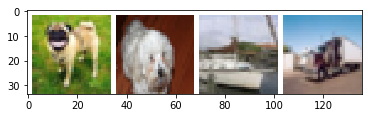

  dog   dog  ship truck


In [10]:
def show(img):
    img = img / 2 + 0.5
    nping = img.numpy()
    plt.imshow(np.transpose(nping, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

show(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16 * 5 * 5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
for epoch in range(8):
    running_loss = 0.
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.

print('training complete')

[1,  2000] loss: 1.214
[1,  4000] loss: 1.207
[1,  6000] loss: 1.185
[1,  8000] loss: 1.189
[1, 10000] loss: 1.172
[1, 12000] loss: 1.180
[2,  2000] loss: 1.097
[2,  4000] loss: 1.102
[2,  6000] loss: 1.088
[2,  8000] loss: 1.108
[2, 10000] loss: 1.102
[2, 12000] loss: 1.097
[3,  2000] loss: 1.008
[3,  4000] loss: 1.031
[3,  6000] loss: 1.052
[3,  8000] loss: 1.031
[3, 10000] loss: 1.055
[3, 12000] loss: 1.035
[4,  2000] loss: 0.929
[4,  4000] loss: 0.964
[4,  6000] loss: 0.981
[4,  8000] loss: 1.015
[4, 10000] loss: 1.010
[4, 12000] loss: 0.974
[5,  2000] loss: 0.908
[5,  4000] loss: 0.913
[5,  6000] loss: 0.915
[5,  8000] loss: 0.936
[5, 10000] loss: 0.959
[5, 12000] loss: 0.960
[6,  2000] loss: 0.868
[6,  4000] loss: 0.875
[6,  6000] loss: 0.892
[6,  8000] loss: 0.908
[6, 10000] loss: 0.915
[6, 12000] loss: 0.906
[7,  2000] loss: 0.828
[7,  4000] loss: 0.849
[7,  6000] loss: 0.865
[7,  8000] loss: 0.862
[7, 10000] loss: 0.877
[7, 12000] loss: 0.890
[8,  2000] loss: 0.792
[8,  4000] 

In [18]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)
#show(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

output = net(images)
_, predicted = torch.max(output, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10,000 test images: 61 %


In [20]:
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s: %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 69 %
Accuracy of   car: 76 %
Accuracy of  bird: 47 %
Accuracy of   cat: 56 %
Accuracy of  deer: 48 %
Accuracy of   dog: 40 %
Accuracy of  frog: 70 %
Accuracy of horse: 66 %
Accuracy of  ship: 81 %
Accuracy of truck: 59 %
